# Thousand

MLPClassifier

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import thousand
from thousand import Player
from sklearn.neural_network import MLPClassifier
from typing import Any
import time
import pickle
from tqdm import trange
from joblib import Parallel, delayed

In [2]:
class SmallestPlayer(Player):

    def make_a_move(self, observation, info):
        return info['correct_moves'][0]


class BiggestPlayer(Player):

    def make_a_move(self, observation, info):
        return info['correct_moves'][-1]


class RandomPlayer(Player):

    def __init__(self, seed=None) -> None:
        self.rng: np.random.Generator = np.random.default_rng(seed)

    def make_a_move(self, observation, info):
        return self.rng.choice(info['correct_moves'])

In [3]:
def generate_session_mlpc(env: gym.Env, options: dict[str, Any], agent: MLPClassifier):
    observations, actions = [], []
    total_reward = 0.0

    observation, info = env.reset(options=options)

    ended = False
    while not ended:
        probability = agent.predict_proba(observation.reshape(1, -1))[0]
        probability /= probability.sum()

        action = np.random.choice(env.action_space.n, p=probability)

        new_observation, reward, terminated, truncated, info = env.step(action)
        ended = terminated or truncated
        observations.append(observation)
        actions.append(action)
        total_reward += reward

        observation = new_observation

    return np.array(observations), np.array(actions), total_reward



In [4]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile):
    n = len(states_batch)
    reward_threshold = np.percentile(rewards_batch, percentile)  

    elite_states = np.empty((0, *states_batch[0].shape[1:]), dtype=states_batch[0].dtype)
    elite_actions = np.empty((0, *actions_batch[0].shape[1:]), dtype=actions_batch[0].dtype)

    for i in range(n):
        if rewards_batch[i] >= reward_threshold:
            elite_states = np.concatenate((elite_states, states_batch[i]))
            elite_actions = np.concatenate((elite_actions, actions_batch[i]))

    return elite_states, elite_actions

In [5]:
def learn_game(env: gym.Env, options: dict[str, Any], agent: MLPClassifier, n_sessions: int, percentile: int,
               n_games: int):
    tr = trange(n_games, desc='mean: 0000; thrs: 0000')
    means = []
    thrs = []
    for i in tr:
        # sessions = [generate_session_mlpc(env, options, agent) for _ in range(n_sessions)]
        sessions = Parallel(n_jobs=-1)(delayed(generate_session_mlpc)(env, options, agent) for _ in range(n_sessions))

        states_batch, actions_batch, rewards_batch = zip(*sessions)

        elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile=percentile)

        reformated_elite_actions = np.zeros((elite_actions.size, env.action_space.n), dtype=int)
        for i in range(elite_actions.size):
            reformated_elite_actions[i][elite_actions[i]] = 1
        agent.fit(elite_states, reformated_elite_actions)

        tr.set_description(
            f'mean: {np.mean(rewards_batch):4.1f}; thrs: {np.percentile(rewards_batch, percentile):4.1f}')
        means.append(np.mean(rewards_batch))
        thrs.append(np.percentile(rewards_batch, percentile))

    return means, thrs

In [6]:
def make_chart(mean, thrs, name):
    fig, ax = plt.subplots()
    ax.set_title('mean and threshold rewards')
    ax.grid()
    ax.plot(mean, label='mean')
    ax.plot(thrs, label='threshold')
    ax.legend()
    fig.savefig(name)

In [7]:
def empty_agent(env: gym.Env, hidden_layer_sizes=(101, 96, 48)):
    agent = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation='tanh', warm_start=True, max_iter=1)

    agent.fit(np.zeros((1, env.observation_space.shape[0]), dtype=int), [[0] * env.action_space.n])
    return agent

In [8]:
def save_agent(agent):
    with open(f'agent{time.time()}.bin', 'wb') as agent_file:
        pickle.dump(agent, agent_file)

In [9]:
def load_agent(name):
    return pickle.load(open(name, 'rb'))

# MLPC

Он не может научиться делать корректные ходы

In [10]:
env = gym.make('Thousand-v0')

In [11]:
agent = empty_agent(env)

/Users/didedoshka/School/ml/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


In [12]:
all_mean, all_thrs = [], []

In [14]:
mean, thrs = learn_game(env, {'players': [SmallestPlayer(), SmallestPlayer()]}, agent, 300, 70, 300)
all_mean += mean
all_thrs += thrs

mean: -445.2; thrs: -307.8: 100%|██████████| 300/300 [04:12<00:00,  1.19it/s]


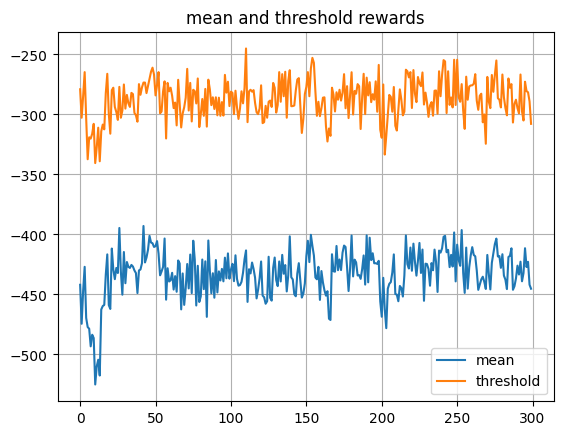

In [15]:
make_chart(all_mean, all_thrs, 'meow.svg')

/Users/didedoshka/School/ml/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
mean: -475.3; thrs: -429.5: 100%|██████████| 200/200 [05:49<00:00,  1.75s/it]
/Users/didedoshka/School/ml/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
mean: -445.2; thrs: -345.2: 100%|██████████| 200/200 [07:53<00:00,  2.37s/it]  
/Users/didedoshka/School/ml/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
mean: -463.8; thrs: -295.5: 100%|██████████| 200/200 [01:37<00:00,  2.04it/s]
/Users/didedoshka

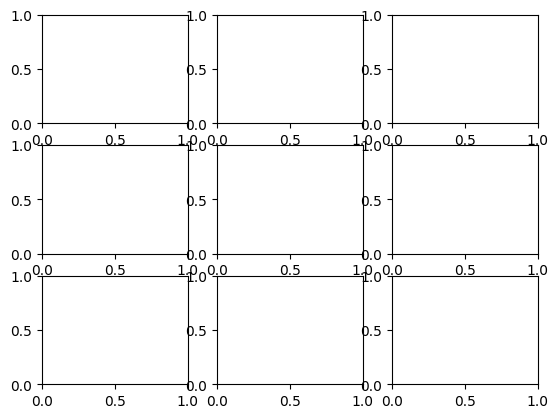

In [16]:
n_sessions = [200, 300, 400]
percentiles = [50, 60, 70]

means, thresholds = [], []

for n_session in n_sessions:
    means.append([])
    thresholds.append([])
    for percentile in percentiles:
        agent = empty_agent(env)
        mean, thrs = learn_game(env, {'players': [SmallestPlayer(), SmallestPlayer()]}, agent, n_session, percentile, 200)
        means[-1].append(mean)
        thresholds[-1].append(thrs)

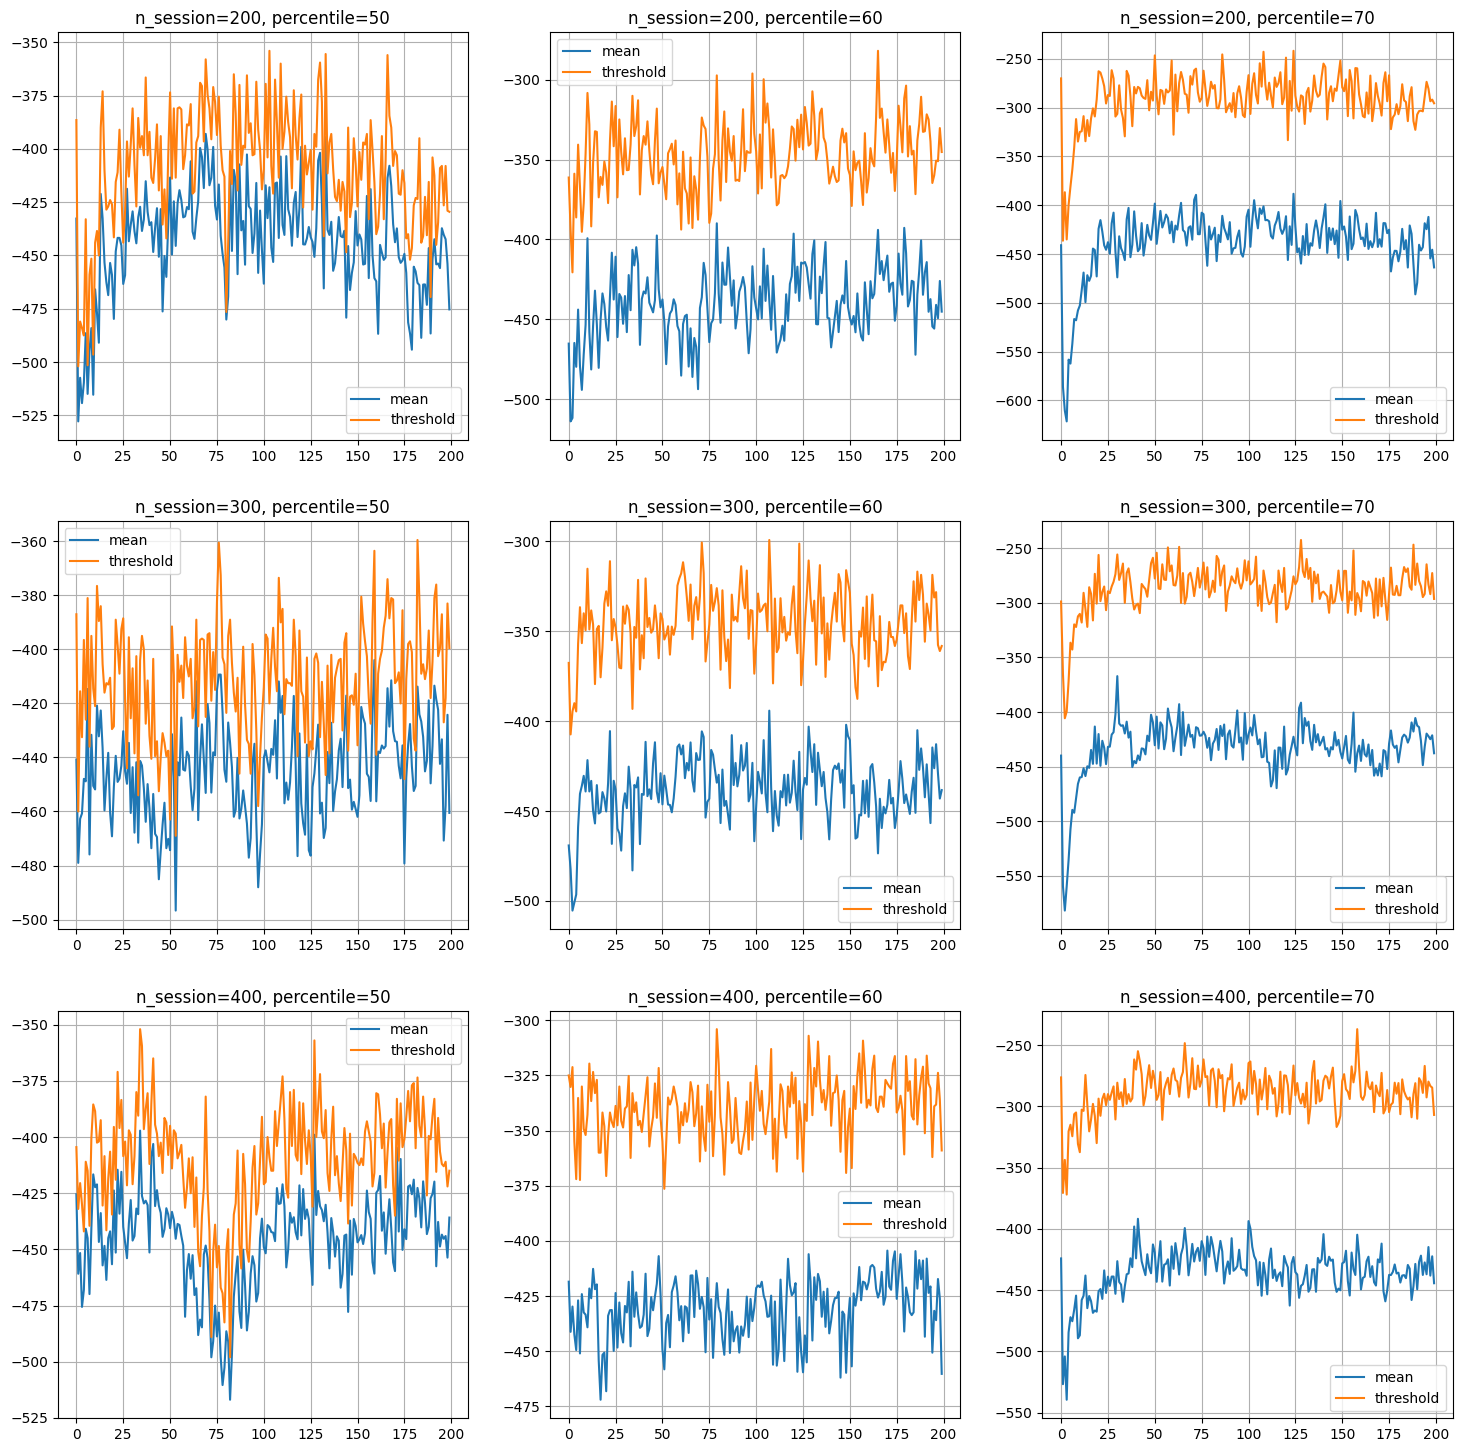

In [19]:
fig, axes = plt.subplots(len(n_sessions), len(percentiles), figsize=(18, 18))

for i in range(len(n_sessions)):
    for j in range(len(percentiles)):
        axes[i][j].grid()
        axes[i][j].set_title(f'n_session={n_sessions[i]}, percentile={percentiles[j]}')
        axes[i][j].plot(means[i][j], label='mean')
        axes[i][j].plot(thresholds[i][j], label='threshold')
        axes[i][j].legend()

fig.savefig('thousandv0.svg')